# Yandex Algorithm 2018 ML track
https://contest.yandex.ru/algorithm2018/contest/7914/standings/
    
15 место (85881) private LB (mi-sol@tut.by)

Результат на public LB для одной модели без усреднения 86615

Регрессия с помощью Catboost, фичи на основе грамматических признаков из pymorphy.

<h1>
  Содержание<span class="tocSkip"></span>
</h1>
<div class="toc">
  <ul class="toc-item">
    <li>
      <span>
        <a href="#Чтение-и-подготовка-данных" data-toc-modified-id="Чтение-и-подготовка-данных-1">
          <span class="toc-item-num">1&nbsp;&nbsp;</span>Чтение и подготовка данных
        </a>
      </span>
      <ul class="toc-item">
        <li>
          <span>
            <a href="#Подготовка-целевой-переменной-для-регрессии" data-toc-modified-id="Подготовка-целевой-переменной-для-регрессии-1.1">
              <span class="toc-item-num">1.1&nbsp;&nbsp;</span>Подготовка целевой переменной для регрессии
            </a>
          </span>
        </li>
      </ul>
    </li>
    <li>
      <span>
        <a href="#Чистка-данных-(ошибки-перекодировки)" data-toc-modified-id="Чистка-данных-(ошибки-перекодировки)-2">
          <span class="toc-item-num">2&nbsp;&nbsp;</span>Чистка данных (ошибки перекодировки)
        </a>
      </span>
    <li>
      <span>
        <a href="#Вычисление-признаков" data-toc-modified-id="Вычисление-признаков-3">
          <span class="toc-item-num">3&nbsp;&nbsp;</span>Вычисление признаков
        </a>
      </span>
      <ul class="toc-item">
        <li>
          <span>
            <a href="#Вычисление-грамматических-признаков" data-toc-modified-id="Вычисление-грамматических-признаков-3.1">
              <span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вычисление грамматических признаков
            </a>
          </span>
        </li>
        <li>
          <span>
            <a href="#Проверяем-одинаковы-ли-род,-время,-число-для-слов-контекста-и-ответа" data-toc-modified-id="Проверяем-одинаковы-ли-род,-время,-число-для-слов-контекста-и-ответа-3.2">
              <span class="toc-item-num">3.2&nbsp;&nbsp;</span>Проверяем одинаковы ли род, время, число для слов контекста и ответа
            </a>
          </span>
        </li>
      </ul>
    </li>
    <li>
      <span>
        <a href="#Исследования" data-toc-modified-id="Исследования-4">
          <span class="toc-item-num">4&nbsp;&nbsp;</span>Исследования
        </a>
      </span>
    </li>
    <li>
      <span>
        <a href="#Обучаемся-и-делаем-предсказание" data-toc-modified-id="Обучаемся-и-делаем-предсказание-5">
          <span class="toc-item-num">5&nbsp;&nbsp;</span>Обучаемся и делаем предсказание
        </a>
      </span>
      <ul class="toc-item">
        <li>
          <span>
            <a href="#Среднее-по-разным-сидам" data-toc-modified-id="Среднее-по-разным-сидам-5.1">
              <span class="toc-item-num">5.1&nbsp;&nbsp;</span>Среднее по разным сидам
            </a>
          </span>
        </li>
      </ul>
    </li>
  </ul>
</div>

In [1]:
import pandas as pd
import numpy as np
import csv 
import re

import pymorphy2
morph = pymorphy2.MorphAnalyzer()

import matplotlib.pyplot as plt

from catboost import CatBoostRegressor

# Чтение и подготовка данных

In [2]:
# читаем данные
train = pd.read_csv('train.tsv', sep='\t', quoting=csv.QUOTE_NONE, header=None, names=[ 'context_id', 'context_2', 'context_1', 'context_0', 'reply_id', 'reply', 'label', 'confidence'])
test = pd.read_csv('final.tsv', sep='\t', quoting=csv.QUOTE_NONE, header=None, names=[ 'context_id', 'context_2', 'context_1', 'context_0', 'reply_id', 'reply'])

## Подготовка целевой переменной для регрессии

Значение confidence всегда меняется от 1/3 (мнения экспертов разделились поровну) до 1 (все эксперты дали одинаковую оценку), эта величина определяет максимальную долю для одной из трёх оценок.

Мы хотим, чтобы значения целивой переменной лежали в следующих диапазонах:

$$good = [\frac{2}{3}, 1]$$ 
$$neutral = [\frac{1}{3}, \frac{2}{3}]$$
$$bad = [0, \frac{2}{3}]$$

при этом 1 - значение целевой переменной для good, когда все эксперты выставили это значение, при расхождении мнения экспертов оно уменьшается до 2/3, 0 - значение целевой переменной для bad, когда все эксперты выставили это значение, при расхождении мнения экспертов оно растёт до 1/3.

Для neutral всё сложнее, т.к. организатры дали confidence только для решения экспертов с максимальным скором, то непонятно в какую сторону смещать neutral, значения confidence могли быть разные. Например:

| good | neutral | bad | |
| --- | --- | --- | --- |
| 0,33 | 0,34 | 0,33 | мнения разделились (неопределённое значение) |
| 0 | 1 | 0 | точно neutral |
| 0,34 | 0,66 | 0 | ближе к good |
| 0 | 0,66 | 0,34 | ближе к bad |

Я решил, что neutral это всё же скорее хорошее значение, поэтому в случаях, когда confidence ближе к 1, то целевая переменная будет ближе к 2/3, а в случае, когда confidence ближе к  0,33 его значение будет 1/3.
Но теперь думаю можно было и вообще всегда ставить для neutral значение 0,5, возможно это улучшило бы результат, хотя и не сильно, т.к. самих значений neutral достаточно мало.

$$y = \begin{cases}
1 - \Delta & \text{good}\\
2/3 - \Delta  & \text{neutral}\\
0 + \Delta  & \text{bad}\\
\end{cases}$$

где $$\Delta = (1 - confidence)/2$$

_Замечу, что тот же принцип давал существенный прирост скора при сортировке результатов в виде вероятностей, 
полученных при применении логистической регрессии для 3-х классов._

In [3]:
# делаем преобразование в соответствии с условиями задачи
# good -> 2, neutral -> 1,  bad -> 0
dict_g_n_b = { 'good': 2, 'neutral': 1, 'bad': 0 }
train['label_num'] = [dict_g_n_b[label] for label in train['label']]

# выставляем начальные значения в крайние точки диапазона (для good и neutral - верхнюю, для bad - нижнюю)
dict_2_1_0 = { 2 : 1, 1 : 2/3, 0: -0.0000001 } # знак "-" для bad, чтобы упростить вычисления
train['y'] = [dict_2_1_0[label] for label in train['label_num']]

# вычисляем смещение по confidence
train['confidence_delta'] = (1.-train['confidence'])/2.
train['y'] = train['y'] - train['confidence_delta']
# меняем обратно знак для bad на +
train.loc[train['y']<0, 'y'] = -train.loc[train['y']<0, 'y']

In [4]:
train[['label', 'label_num', 'confidence', 'confidence_delta', 'y']].head()

,label,label_num,confidence,confidence_delta,y
0,good,2,0.875352,0.062324,0.937676
1,neutral,1,0.900968,0.049516,0.617151
2,bad,0,0.884320,0.057840,0.057840
3,good,2,0.982530,0.008735,0.991265
4,good,2,0.838054,0.080973,0.919027


In [5]:
# сливаем train и test вместе
train['is_train'] = True
test['is_train'] = False
all_data = pd.concat([train , test], ignore_index=True)

In [6]:
all_data.fillna('', inplace=True)

# Чистка данных (ошибки перекодировки)

Очистка данных давала прирост на валиации и LB.

Ошибки получены, вероятно, в результате неправильной перекодировки из Win-1251 в macCyrillic и последующем приведении к нижнему регистру и отделении знаков препинания от слов (что также добавило ошибок в слова с апострофами), в результате разные буквы могли получить один и тот же код, что мешало сделать автоматическое восстановление.

Например:
<br>_Боже Пожалуйста -> Ѕоже ѕожалуйста -> sоже ѕожалуйста
<br>Да -> ƒа
<br>Он -> ќн
<br>Такой -> “акой -> " акой_

In [7]:
%%time
# исправление ошибок перекодировки
def correct_encoding(field_name):
    all_data[field_name] = all_data[field_name].str.replace('ьi', 'ы')
    all_data[field_name] = all_data[field_name].str.replace('ќа', 'на')
    all_data[field_name] = all_data[field_name].str.replace('ќе', 'не')
    all_data[field_name] = all_data[field_name].str.replace('ќу', 'ну')
    all_data[field_name] = all_data[field_name].str.replace('ќи', 'ни')
    all_data[field_name] = all_data[field_name].str.replace('ќо', 'но')
    all_data[field_name] = all_data[field_name].str.replace('ќ', 'о')
    all_data[field_name] = all_data[field_name].str.replace('\' орош', 'хорош')
    all_data[field_name] = all_data[field_name].str.replace('ѕоже', 'боже')
    all_data[field_name] = all_data[field_name].str.replace('ѕорис', 'борис')
    all_data[field_name] = all_data[field_name].str.replace('sольш', 'больш')
    all_data[field_name] = all_data[field_name].str.replace('ѕи', ' би')
    all_data[field_name] = all_data[field_name].str.replace('ѕе', 'бе')
    all_data[field_name] = all_data[field_name].str.replace('ѕо', 'по')
    all_data[field_name] = all_data[field_name].str.replace('ѕр', 'пр')
    all_data[field_name] = all_data[field_name].str.replace('ћа', 'ла')
    all_data[field_name] = all_data[field_name].str.replace('ћю', 'лю')
    all_data[field_name] = all_data[field_name].str.replace('ћ', 'м')
    all_data[field_name] = all_data[field_name].str.replace('єм', 'ём')
    all_data[field_name] = all_data[field_name].str.replace('єл', 'ял')
    all_data[field_name] = all_data[field_name].str.replace(' є', ' я')
    all_data[field_name] = all_data[field_name].str.replace('" є', 'чё')
    all_data[field_name] = all_data[field_name].str.replace('є', 'ё')
    all_data[field_name] = all_data[field_name].str.replace('¬', 'в')
    all_data[field_name] = all_data[field_name].str.replace('" ы', 'ты')
    all_data[field_name] = all_data[field_name].str.replace('" й', 'уй')
    all_data[field_name] = all_data[field_name].str.replace('" олько', 'только')
correct_encoding('reply')
correct_encoding('context_0')
correct_encoding('context_1')
correct_encoding('context_2')

Wall time: 19.2 s


In [8]:
%%time
# зачистка текста от знаков препинания
def replace_punctuation(field_name):
    all_data[field_name] = all_data[field_name].str.replace('-', '')
    all_data[field_name] = all_data[field_name].str.replace('!', '')
    all_data[field_name] = all_data[field_name].str.replace('.', '')
    all_data[field_name] = all_data[field_name].str.replace(',', '')
    all_data[field_name] = all_data[field_name].str.replace('"', '')
    all_data[field_name] = all_data[field_name].str.replace('\'', '')
    all_data[field_name] = all_data[field_name].str.replace('  ', ' ')
    all_data[field_name] = all_data[field_name].str.replace('  ', ' ')
replace_punctuation('reply')
replace_punctuation('context_0')
replace_punctuation('context_1')
replace_punctuation('context_2')

Wall time: 4.38 s


при более тщательной очистке данных скор упал, поэтому от неё в таком виде отказался

# Вычисление признаков

In [9]:
%%time
# длина ответа в символах
all_data['reply_char_len'] = train['reply'].str.len()

Wall time: 48 ms


In [10]:
%%time
# делим на слова, помещаем их в списки
field_name = 'reply'
all_data[field_name+'_words'] = [re.sub("[^a-zа-яё]"," ", field).lower().split() for field in all_data[field_name]]
field_name = 'context_0'
all_data[field_name+'_words'] = [re.sub("[^a-zа-яё]"," ", field).lower().split() for field in all_data[field_name]]
field_name = 'context_1'
all_data[field_name+'_words'] = [re.sub("[^a-zа-яё]"," ", field).lower().split() for field in all_data[field_name]]
field_name = 'context_2'
all_data[field_name+'_words'] = [re.sub("[^a-zа-яё]"," ", field).lower().split() for field in all_data[field_name]]

Wall time: 3.51 s


In [11]:
%%time
# длина ближайшего контекста и ответа в словах
field_name = 'reply'
all_data[field_name+'_word_len'] = all_data[field_name+'_words'].apply(lambda x: len(x))
field_name = 'context_0'
all_data[field_name+'_word_len'] = all_data[field_name+'_words'].apply(lambda x: len(x))

Wall time: 155 ms


In [12]:
%%time
# Количество и доля одинаковых слов в вопросе и в отвее
all_data['reply_context_0_intersection_count'] = [len(set(row.loc['reply_words']).intersection(row.loc['context_0_words'])) for index, row in all_data.iterrows()]
all_data['reply_context_0_intersection_part'] = [len(set(row.loc['reply_words']).intersection(row.loc['context_0_words']))/(len(set(row.loc['reply_words']))+1) for index, row in all_data.iterrows()]

Wall time: 1min 5s


In [13]:
# фразы полностью совпадает
all_data['reply_equel_context_0'] = False
all_data.loc[all_data['context_0'] == all_data['reply'], 'reply_equel_context_0'] = True

In [14]:
all_data['reply_equel_context_1'] = False
all_data.loc[all_data['context_1'] == all_data['reply'], 'reply_equel_context_1'] = True

In [15]:
all_data['reply_equel_context_2'] = False
all_data.loc[all_data['context_2'] == all_data['reply'], 'reply_equel_context_2'] = True

In [16]:
%%time
# фразы типа -он всё знает, -что значит "всё знает"
all_data['what_mean'] = all_data['reply'].str.extract('что значит ([^?]*) ?', expand=False).str.strip()
all_data['what_mean_same'] = False
all_data.loc[all_data['what_mean'].notnull(), 'what_mean_same'] = [x[0] in x[1] for x in zip(all_data[all_data['what_mean'].notnull()]['what_mean'], all_data[all_data['what_mean'].notnull()]['context_0'])]

Wall time: 259 ms


In [17]:
# проверка, что что-то нашлось
len(all_data[all_data['what_mean'].notnull()])

600

In [18]:
len(all_data[all_data['what_mean_same']])

325

In [19]:
# первое слово
field_name = 'reply'
all_data[field_name + '_first_word'] = ''
all_data[field_name + '_first_word'] = all_data[all_data[field_name + '_word_len'] > 0][field_name + '_words'].apply(lambda x: x[0])
all_data[field_name + '_first_word'].fillna('', inplace=True)
field_name = 'context_0'
all_data[field_name + '_first_word'] = ''
all_data[field_name + '_first_word'] = all_data[all_data[field_name + '_word_len'] > 0][field_name + '_words'].apply(lambda x: x[0])
all_data[field_name + '_first_word'].fillna('', inplace=True)

In [20]:
# последнее слово
field_name = 'reply'
all_data[field_name + '_last_word'] = ''
all_data[field_name + '_last_word'] = all_data[all_data[field_name + '_word_len'] > 0][field_name + '_words'].apply(lambda x: x[-1])
all_data[field_name + '_last_word'].fillna('', inplace=True)
field_name = 'context_0'
all_data[field_name + '_last_word'] = ''
all_data[field_name + '_last_word'] = all_data[all_data[field_name + '_word_len'] > 0][field_name + '_words'].apply(lambda x: x[-1])
all_data[field_name + '_last_word'].fillna('', inplace=True)

In [21]:
# наличие местоимений в вопросе и ответе
# ты - я
all_data['you_i'] = False
all_data.loc[all_data['context_0_words'].apply(lambda x: 'ты' in x) & all_data['reply_words'].apply(lambda x: 'я' in x), 'you_i'] = True

In [22]:
# я - ты
all_data['i_you'] = False
all_data.loc[all_data['context_0_words'].apply(lambda x: 'я' in x) & all_data['reply_words'].apply(lambda x: 'ты' in x), 'i_you'] = True

In [23]:
# он - он
all_data['he_he'] = False
all_data.loc[all_data['context_0_words'].apply(lambda x: 'он' in x) & all_data['reply_words'].apply(lambda x: 'он' in x), 'he_he'] = True

In [24]:
# она - она
all_data['she_she'] = False
all_data.loc[all_data['context_0_words'].apply(lambda x: 'она' in x) & all_data['reply_words'].apply(lambda x: 'она' in x), 'she_she'] = True

In [25]:
# учёт различных приветствий 
# возможно тут лучше было сделать 3 значения
# - нет приветствия ни в одной из фраз
# - есть приветствие только в одной из фраз
# - есть соответствующие приветствия в обеих фразах (да и соответствие я не учитывал)
greetings = ['привет', 'прощай', 'прощайте', 'спокойной ночи', 'доброй ночи', 'добрый вечер', 'добрый день', 'сладких снов', 'здравствуй', 'здравствуйте', 'пока', 'салют', 'алло', 'до свидания', 'всего доброго', 'здорово', 'здоров', 'хай', 'бывайте', 'бывай', 'будь', 'до встречи', 'увидемся', 'услышимся']
thanks = ['спасибо', 'благодарю', 'благодарен', 'благодарим']
wellcome = ['пожалуйста', 'не за что', 'незачто', 'на здоровье', 'не стоит благодарности', 'мелочи', 'обращайтесь']

In [26]:
all_data['hello_hello'] = False
all_data.loc[all_data['context_0_words'].apply(lambda x: any(gr in x for gr in greetings)) & all_data['reply_words'].apply(lambda x: any(gr in x for gr in greetings)), 'hello_hello'] = True

In [27]:
# проверим, что получилось
len(all_data[all_data['hello_hello'] & all_data['is_train']]), len(all_data[all_data['hello_hello'] & ~all_data['is_train']])

(662, 808)

In [28]:
all_data['thanks_wellcome'] = False
all_data.loc[all_data['context_0_words'].apply(lambda x: any(gr in x for gr in thanks)) & all_data['reply_words'].apply(lambda x: any(gr in x for gr in wellcome)), 'thanks_wellcome'] = True

In [29]:
# проверим, что получилось
len(all_data[all_data['thanks_wellcome'] & all_data['is_train']]), len(all_data[all_data['thanks_wellcome'] & ~all_data['is_train']])

(326, 294)

In [30]:
# вопросительное предложение
field_name = 'reply'
all_data[field_name + '_question'] = all_data[field_name].apply(lambda x: x[-1:])=='?'
field_name = 'context_0'
all_data[field_name + '_question'] = all_data[field_name].apply(lambda x: x[-1:])=='?'

## Вычисление грамматических признаков

In [31]:
# грамматические признаки первого и последнего слова
# наличие грамматической характеристики во фразе
# использование "at" на порядок ускоряет вычисления

def make_gramma(df, field_names):
    for field_name in field_names:
        df[field_name + '_gramm_order'] = '' # порядок следования частей речи во фразе

        df[field_name + '_gramm_pos_first'] = ''
        df[field_name + '_gramm_case_first'] = ''
        df[field_name + '_gramm_gender_first'] = ''
        df[field_name + '_gramm_number_first'] = ''
        df[field_name + '_gramm_animacy_first'] = ''
        df[field_name + '_gramm_tense_first'] = ''
        df[field_name + '_gramm_aspect_first'] = ''
        df[field_name + '_gramm_person_first'] = ''
        df[field_name + '_gramm_involvement_first'] = ''
        df[field_name + '_gramm_mood_first'] = ''
        df[field_name + '_gramm_transitivity_first'] = ''
        df[field_name + '_gramm_voice_first'] = ''
        
        df[field_name + '_gramm_pos_last'] = ''
        df[field_name + '_gramm_case_last'] = ''
        df[field_name + '_gramm_gender_last'] = ''
        df[field_name + '_gramm_number_last'] = ''
        df[field_name + '_gramm_animacy_last'] = ''
        df[field_name + '_gramm_tense_last'] = ''
        df[field_name + '_gramm_aspect_last'] = ''
        df[field_name + '_gramm_person_last'] = ''
        df[field_name + '_gramm_involvement_last'] = ''
        df[field_name + '_gramm_mood_last'] = ''
        df[field_name + '_gramm_transitivity_last'] = ''
        df[field_name + '_gramm_voice_last'] = ''

        df[field_name + '_gramm_name'] = False
        df[field_name + '_gramm_surn'] = False
        df[field_name + '_gramm_patr'] = False
        df[field_name + '_gramm_geox'] = False
        df[field_name + '_gramm_orgn'] = False
        df[field_name + '_gramm_qual'] = False
        df[field_name + '_gramm_anum'] = False
        df[field_name + '_gramm_apro'] = False
    for i, row in df.iterrows():
        for field_name in field_names:
            for word in row[field_name + '_words']:
                sem = morph.parse(word)[0]
                if sem.tag.POS:
                    df.at[i, field_name + '_gramm_order'] += str(sem.tag.POS)
                    if df.at[i, field_name + '_gramm_pos_first'] == '':
                        df.at[i, field_name + '_gramm_pos_first'] = str(sem.tag.POS)
                    df.at[i, field_name + '_gramm_pos_last'] = str(sem.tag.POS)
                    df.at[i, field_name + '_gramm_pos_' + sem.tag.POS] = True
                if sem.tag.case:
                    if df.at[i, field_name + '_gramm_case_first'] == '':
                        df.at[i, field_name + '_gramm_case_first'] = str(sem.tag.case)
                    df.at[i, field_name + '_gramm_case_last'] = str(sem.tag.case)
                    df.at[i, field_name + '_gramm_case_' + sem.tag.case] = True
                if sem.tag.gender:
                    if df.at[i, field_name + '_gramm_gender_first'] == '':
                        df.at[i, field_name + '_gramm_gender_first'] = str(sem.tag.gender)
                    df.at[i, field_name + '_gramm_gender_last'] = str(sem.tag.gender)
                    df.at[i, field_name + '_gramm_gender_' + sem.tag.gender] = True
                if sem.tag.number:
                    if df.at[i, field_name + '_gramm_number_first'] == '':
                        df.at[i, field_name + '_gramm_number_first'] = str(sem.tag.number)
                    df.at[i, field_name + '_gramm_number_last'] = str(sem.tag.number)
                    df.at[i, field_name + '_gramm_number_' + sem.tag.number] = True
                if sem.tag.animacy:
                    if df.at[i, field_name + '_gramm_animacy_first'] == '':
                        df.at[i, field_name + '_gramm_animacy_first'] = str(sem.tag.animacy)
                    df.at[i, field_name + '_gramm_animacy_last'] = str(sem.tag.animacy)
                    df.at[i, field_name + '_gramm_animacy_' + sem.tag.animacy] = True
                if sem.tag.tense:
                    if df.at[i, field_name + '_gramm_tense_first'] == '':
                        df.at[i, field_name + '_gramm_tense_first'] = str(sem.tag.tense)
                    df.at[i, field_name + '_gramm_tense_last'] = str(sem.tag.tense)
                    df.at[i, field_name + '_gramm_tense_' + sem.tag.tense] = True
                if sem.tag.aspect:
                    if df.at[i, field_name + '_gramm_aspect_first'] == '':
                        df.at[i, field_name + '_gramm_aspect_first'] = str(sem.tag.aspect)
                    df.at[i, field_name + '_gramm_aspect_last'] = str(sem.tag.aspect)
                    df.at[i, field_name + '_gramm_aspect_' + sem.tag.aspect] = True
                if sem.tag.person:
                    if df.at[i, field_name + '_gramm_person_first'] == '':
                        df.at[i, field_name + '_gramm_person_first'] = str(sem.tag.person)
                    df.at[i, field_name + '_gramm_person_last'] = str(sem.tag.person)
                    df.at[i, field_name + '_gramm_person_' + sem.tag.person] = True
                if sem.tag.involvement:
                    if df.at[i, field_name + '_gramm_involvement_first'] == '':
                        df.at[i, field_name + '_gramm_involvement_first'] = str(sem.tag.involvement)
                    df.at[i, field_name + '_gramm_involvement_last'] = str(sem.tag.involvement)
                    df.at[i, field_name + '_gramm_involvement_' + sem.tag.involvement] = True
                if sem.tag.mood:
                    if df.at[i, field_name + '_gramm_mood_first'] == '':
                        df.at[i, field_name + '_gramm_mood_first'] = str(sem.tag.mood)
                    df.at[i, field_name + '_gramm_mood_last'] = str(sem.tag.mood)
                    df.at[i, field_name + '_gramm_mood_' + sem.tag.mood] = True
                if sem.tag.transitivity:
                    if df.at[i, field_name + '_gramm_transitivity_first'] == '':
                        df.at[i, field_name + '_gramm_transitivity_first'] = str(sem.tag.transitivity)
                    df.at[i, field_name + '_gramm_transitivity_last'] = str(sem.tag.transitivity)
                    df.at[i, field_name + '_gramm_transitivity_' + sem.tag.transitivity] = True
                if sem.tag.voice:
                    if df.at[i, field_name + '_gramm_voice_first'] == '':
                        df.at[i, field_name + '_gramm_voice_first'] = str(sem.tag.voice)
                    df.at[i, field_name + '_gramm_voice_last'] = str(sem.tag.voice)
                    df.at[i, field_name + '_gramm_voice_' + sem.tag.voice] = True
                
                if ~df.at[i, field_name + '_gramm_name']:
                    df.at[i, field_name + '_gramm_name'] = 'Name' in sem.tag
                if ~df.at[i, field_name + '_gramm_surn']:
                    df.at[i, field_name + '_gramm_surn'] = 'Surn' in sem.tag
                if ~df.at[i, field_name + '_gramm_patr']:
                    df.at[i, field_name + '_gramm_patr'] = 'Patr' in sem.tag
                if ~df.at[i, field_name + '_gramm_geox']:
                    df.at[i, field_name + '_gramm_geox'] = 'Geox' in sem.tag
                if ~df.at[i, field_name + '_gramm_orgn']:
                    df.at[i, field_name + '_gramm_orgn'] = 'Orgn' in sem.tag
                if ~df.at[i, field_name + '_gramm_qual']:
                    df.at[i, field_name + '_gramm_qual'] = 'Qual' in sem.tag
                if ~df.at[i, field_name + '_gramm_anum']:
                    df.at[i, field_name + '_gramm_anum'] = 'Anum' in sem.tag
                if ~df.at[i, field_name + '_gramm_apro']:
                    df.at[i, field_name + '_gramm_apro'] = 'Apro' in sem.tag
    df.fillna(False, inplace=True)

In [32]:
%%time
make_gramma(all_data, ['reply', 'context_0'])

Wall time: 20min 28s


## Проверяем одинаковы ли род, время, число для слов контекста и ответа
надо помнить, что это делается только для последнего слова во фразе имеющего грамматическую характеристику такого типа, а не для, скажем, подлежащего или сказуемого

In [33]:
# совпадения для первых слов
# совпадает падеж
all_data['reply_first_context_0_first_same_case'] = False
all_data.loc[all_data['context_0_gramm_case_first'] == all_data['reply_gramm_case_first'], 'reply_first_context_0_first_same_case'] = True

# совпадает род
all_data['reply_first_context_0_first_same_gender'] = False
all_data.loc[all_data['context_0_gramm_gender_first'] == all_data['reply_gramm_gender_first'], 'reply_first_context_0_first_same_gender'] = True

# совпадает число
all_data['reply_first_context_0_first_same_number'] = False
all_data.loc[all_data['context_0_gramm_number_first'] == all_data['reply_gramm_number_first'], 'reply_first_context_0_first_same_number'] = True

# совпадает время
all_data['reply_first_context_0_first_same_tense'] = False
all_data.loc[all_data['context_0_gramm_tense_first'] == all_data['reply_gramm_tense_first'], 'reply_first_context_0_first_same_tense'] = True

In [34]:
# совпадения для первых слов ответа с последним словом контекста
# совпадает падеж
all_data['reply_first_context_0_last_same_case'] = False
all_data.loc[all_data['context_0_gramm_case_last'] == all_data['reply_gramm_case_first'], 'reply_first_context_0_last_same_case'] = True

# совпадает род
all_data['reply_first_context_0_last_same_gender'] = False
all_data.loc[all_data['context_0_gramm_gender_last'] == all_data['reply_gramm_gender_first'], 'reply_first_context_0_last_same_gender'] = True

# совпадает число
all_data['reply_first_context_0_last_same_number'] = False
all_data.loc[all_data['context_0_gramm_number_last'] == all_data['reply_gramm_number_first'], 'reply_first_context_0_last_same_number'] = True

# совпадает время
all_data['reply_first_context_0_last_same_tense'] = False
all_data.loc[all_data['context_0_gramm_tense_last'] == all_data['reply_gramm_tense_first'], 'reply_first_context_0_last_same_tense'] = True

In [35]:
# совпадает третье лицо
all_data['reply_context_0_same_3per'] = False
all_data.loc[all_data['context_0_gramm_person_3per'] & all_data['reply_gramm_person_3per'], 'reply_context_0_same_3per'] = True

Почитав материалы очередного семинара курса DMiA, решил, что будет полезно избавится от низкочастотных значений, так и оказалось, скор существенно вырос

In [36]:
# удалим низкочастотные фразы и сочетания частей речи
col = 'reply_gramm_order'
new_col = col + '_rife'
all_data[new_col] = all_data[col]
all_data.loc[all_data[new_col].value_counts()[all_data[new_col]].values < 30, new_col] = '<RARE_VALUE>'

col = 'context_0_gramm_order'
new_col = col + '_rife'
all_data[new_col] = all_data[col]
all_data.loc[all_data[new_col].value_counts()[all_data[new_col]].values < 30, new_col] = '<RARE_VALUE>'

col = 'reply'
new_col = col + '_rife'
all_data[new_col] = all_data[col]
all_data.loc[all_data[new_col].value_counts()[all_data[new_col]].values < 30, new_col] = '<RARE_VALUE>'

col = 'context_0'
new_col = col + '_rife'
all_data[new_col] = all_data[col]
all_data.loc[all_data[new_col].value_counts()[all_data[new_col]].values < 30, new_col] = '<RARE_VALUE>'

col = 'context_1'
new_col = col + '_rife'
all_data[new_col] = all_data[col]
all_data.loc[all_data[new_col].value_counts()[all_data[new_col]].values < 30, new_col] = '<RARE_VALUE>'

col = 'context_2'
new_col = col + '_rife'
all_data[new_col] = all_data[col]
all_data.loc[all_data[new_col].value_counts()[all_data[new_col]].values < 30, new_col] = '<RARE_VALUE>'

In [37]:
# удалим низкочастотные первые слова
col = 'reply_first_word'
new_col = col + '_rife'
all_data[new_col] = all_data[col]
all_data.loc[all_data[new_col].value_counts()[all_data[new_col]].values < 30, new_col] = ''

col = 'context_0_first_word'
new_col = col + '_rife'
all_data[new_col] = all_data[col]
all_data.loc[all_data[new_col].value_counts()[all_data[new_col]].values < 30, new_col] = ''

In [38]:
# удалим низкочастотные последние слова
col = 'reply_last_word'
new_col = col + '_rife'
all_data[new_col] = all_data[col]
all_data.loc[all_data[new_col].value_counts()[all_data[new_col]].values < 30, new_col] = ''

col = 'context_0_last_word'
new_col = col + '_rife'
all_data[new_col] = all_data[col]
all_data.loc[all_data[new_col].value_counts()[all_data[new_col]].values < 30, new_col] = ''

In [39]:
%%time
train = all_data[all_data['is_train']].drop(['is_train'], axis = 1)
test = all_data[~all_data['is_train']].drop(['is_train'], axis = 1)

Wall time: 840 ms


In [40]:
# проконтролируем результат
train.columns, test.columns

(Index(['confidence', 'confidence_delta', 'context_0', 'context_1', 'context_2',
        'context_id', 'label', 'label_num', 'reply', 'reply_id',
        ...
        'reply_gramm_order_rife', 'context_0_gramm_order_rife', 'reply_rife',
        'context_0_rife', 'context_1_rife', 'context_2_rife',
        'reply_first_word_rife', 'context_0_first_word_rife',
        'reply_last_word_rife', 'context_0_last_word_rife'],
       dtype='object', length=220),
 Index(['confidence', 'confidence_delta', 'context_0', 'context_1', 'context_2',
        'context_id', 'label', 'label_num', 'reply', 'reply_id',
        ...
        'reply_gramm_order_rife', 'context_0_gramm_order_rife', 'reply_rife',
        'context_0_rife', 'context_1_rife', 'context_2_rife',
        'reply_first_word_rife', 'context_0_first_word_rife',
        'reply_last_word_rife', 'context_0_last_word_rife'],
       dtype='object', length=220))

## Исследования

подсчитаем частоту слов (на частотные слова следует обратить особенное внимание)
для диалогов частотными оказались местоимения, поэтому для них делал отдельные фичи (далеко не все что можно было бы)

In [41]:
import itertools
from collections import Counter

In [42]:
# в train context_0
words = list(itertools.chain(*train['context_0_words']))
print(Counter(words).most_common(100))

[('я', 17413), ('не', 14793), ('что', 12126), ('ты', 9693), ('это', 8703), ('и', 7864), ('в', 7794), ('на', 4573), ('с', 4466), ('нет', 4158), ('он', 4036), ('да', 3847), ('мы', 3734), ('как', 3565), ('мне', 3560), ('вы', 3476), ('меня', 3167), ('у', 3137), ('так', 3126), ('но', 3041), ('то', 2895), ('тебя', 2728), ('а', 2640), ('его', 2283), ('она', 2280), ('все', 2203), ('о', 2117), ('тебе', 2115), ('за', 1945), ('если', 1898), ('бы', 1808), ('просто', 1661), ('есть', 1501), ('они', 1474), ('ну', 1459), ('кто', 1456), ('хорошо', 1446), ('из', 1435), ('чтобы', 1435), ('же', 1426), ('знаю', 1375), ('здесь', 1353), ('для', 1282), ('может', 1245), ('по', 1245), ('только', 1244), ('когда', 1240), ('было', 1219), ('вот', 1162), ('спасибо', 1161), ('всё', 1159), ('был', 1109), ('быть', 1092), ('вас', 1086), ('могу', 1081), ('почему', 1048), ('хочу', 1020), ('нас', 1015), ('к', 1001), ('где', 945), ('вам', 936), ('ладно', 920), ('нужно', 912), ('будет', 907), ('уже', 901), ('знаешь', 889), (

In [43]:
# в train reply
words = list(itertools.chain(*train['reply_words']))
print(Counter(words).most_common(100))

[('не', 17451), ('я', 17294), ('что', 11145), ('и', 8513), ('ты', 7065), ('нет', 6605), ('это', 6423), ('в', 6382), ('да', 5811), ('он', 4641), ('мы', 3513), ('но', 3204), ('на', 3162), ('с', 3145), ('а', 3080), ('мне', 2961), ('она', 2837), ('меня', 2783), ('его', 2728), ('вы', 2542), ('у', 2493), ('то', 2407), ('тебя', 2390), ('как', 2292), ('так', 2238), ('хорошо', 1892), ('за', 1882), ('все', 1840), ('тебе', 1823), ('знаю', 1761), ('ничего', 1715), ('тоже', 1687), ('о', 1634), ('ну', 1499), ('если', 1488), ('просто', 1382), ('они', 1365), ('бы', 1363), ('же', 1358), ('тогда', 1357), ('был', 1241), ('есть', 1207), ('здесь', 1160), ('очень', 1159), ('может', 1149), ('только', 1136), ('конечно', 1131), ('для', 1100), ('было', 1067), ('могу', 1044), ('потому', 1003), ('чтобы', 992), ('спасибо', 975), ('ее', 971), ('из', 942), ('быть', 939), ('вас', 936), ('будет', 903), ('кто', 887), ('всё', 871), ('хочу', 864), ('вот', 858), ('уже', 858), ('думаю', 855), ('по', 836), ('еще', 834), ('н

In [44]:
# в test context_0
words = list(itertools.chain(*test['context_0_words']))
print(Counter(words).most_common(100))

[('я', 18547), ('не', 16072), ('что', 14017), ('ты', 11069), ('это', 9266), ('и', 8742), ('в', 8676), ('на', 5042), ('с', 4480), ('нет', 4292), ('да', 4195), ('он', 4104), ('мы', 4069), ('мне', 4042), ('как', 3813), ('вы', 3807), ('у', 3612), ('меня', 3577), ('так', 3434), ('то', 3330), ('но', 3050), ('а', 2961), ('тебя', 2703), ('все', 2679), ('она', 2645), ('о', 2430), ('его', 2356), ('тебе', 2201), ('если', 2138), ('за', 2086), ('бы', 1835), ('просто', 1806), ('знаю', 1737), ('же', 1727), ('хорошо', 1726), ('кто', 1623), ('ну', 1620), ('здесь', 1602), ('они', 1601), ('чтобы', 1566), ('когда', 1479), ('всё', 1464), ('из', 1449), ('есть', 1440), ('был', 1383), ('было', 1272), ('для', 1245), ('по', 1234), ('вас', 1198), ('только', 1185), ('может', 1174), ('нас', 1147), ('могу', 1141), ('почему', 1132), ('к', 1080), ('от', 1060), ('вот', 1058), ('спасибо', 1029), ('знаешь', 1029), ('уже', 1020), ('чем', 1002), ('быть', 1000), ('нужно', 998), ('сейчас', 993), ('ладно', 981), ('будет', 97

In [45]:
# в test reply
words = list(itertools.chain(*test['reply_words']))
print(Counter(words).most_common(100))

[('не', 18990), ('я', 18641), ('что', 11989), ('и', 9118), ('ты', 7861), ('нет', 7033), ('это', 6984), ('в', 6727), ('да', 6354), ('он', 5229), ('мы', 3761), ('но', 3500), ('на', 3480), ('с', 3292), ('а', 3201), ('мне', 3061), ('она', 3035), ('меня', 2939), ('его', 2837), ('вы', 2791), ('у', 2639), ('то', 2537), ('как', 2479), ('так', 2376), ('тебя', 2364), ('хорошо', 2072), ('за', 2058), ('тебе', 2009), ('знаю', 1955), ('ничего', 1945), ('все', 1943), ('о', 1899), ('тоже', 1831), ('просто', 1672), ('ну', 1650), ('бы', 1587), ('если', 1581), ('же', 1533), ('они', 1494), ('тогда', 1424), ('был', 1415), ('есть', 1362), ('здесь', 1273), ('может', 1247), ('только', 1242), ('конечно', 1194), ('очень', 1149), ('для', 1144), ('было', 1142), ('потому', 1090), ('чтобы', 1090), ('могу', 1047), ('вас', 1041), ('ее', 1030), ('кто', 995), ('быть', 971), ('еще', 962), ('из', 960), ('спасибо', 951), ('будет', 945), ('думаю', 945), ('всё', 943), ('знаешь', 924), ('чем', 909), ('хочу', 900), ('по', 891

In [46]:
# распределение оценок
train['label'].value_counts(normalize=True)

good       0.528119
bad        0.356495
neutral    0.115387
Name: label, dtype: float64

Подсчитаем распределение оценок для разных признаков, если их распределение совпадает с основным, то вероятно этот признак не будет иметь большого значения. Но так как оставалась надежда на сочетания разных признаков, то всё равно все оставил.

In [47]:
train[train['reply_equel_context_0']==True]['label'].value_counts(normalize=True)

bad        0.867889
neutral    0.099874
good       0.032238
Name: label, dtype: float64

In [48]:
train[train['thanks_wellcome']]['label'].value_counts(normalize=True)

good       0.754601
neutral    0.205521
bad        0.039877
Name: label, dtype: float64

подсчитаем частоту сочетаний личных местоимений (примерно, не учитываются местоимения в начале фразы)

In [49]:
train[train['context_0'].str.contains(' он ') & train['reply'].str.contains(' он ')]['label'].value_counts(normalize=True)

good       0.673664
bad        0.297710
neutral    0.028626
Name: label, dtype: float64

In [50]:
train[train['context_0'].str.contains(' она ') & train['reply'].str.contains(' она ')]['label'].value_counts(normalize=True)

good       0.597561
bad        0.394309
neutral    0.008130
Name: label, dtype: float64

In [51]:
train[train['context_0'].str.contains(' он ') & train['reply'].str.contains(' она ')]['label'].value_counts(normalize=True)

good    0.75
bad     0.25
Name: label, dtype: float64

In [52]:
train[train['context_0'].str.contains(' она ') & train['reply'].str.contains(' он ')]['label'].value_counts(normalize=True)

good       0.500000
bad        0.428571
neutral    0.071429
Name: label, dtype: float64

In [53]:
train[train['context_0'].str.contains(' я ') & train['reply'].str.contains(' я ')]['label'].value_counts(normalize=True)

good       0.549020
bad        0.397759
neutral    0.053221
Name: label, dtype: float64

In [54]:
train[train['context_0'].str.contains(' я ') & train['reply'].str.contains(' ты ')]['label'].value_counts(normalize=True)

good       0.624044
bad        0.345355
neutral    0.030601
Name: label, dtype: float64

In [55]:
train[train['context_0'].str.contains(' ты ') & train['reply'].str.contains(' я ')]['label'].value_counts()

good       722
bad        326
neutral     89
Name: label, dtype: int64

In [56]:
train[train['context_0'].str.contains(' ты ') & train['reply'].str.contains(' ты ')]['label'].value_counts(normalize=True)

good       0.594891
bad        0.375912
neutral    0.029197
Name: label, dtype: float64

In [57]:
train[train['context_0'].str.contains(' тоже ') & train['reply'].str.contains(' тоже ')]['label'].value_counts(normalize=True)

bad        0.689655
neutral    0.172414
good       0.137931
Name: label, dtype: float64

In [58]:
# совпадение контекста и ответа
train[train['context_0'] == train['reply']]['label'].value_counts(normalize=True)

bad        0.867889
neutral    0.099874
good       0.032238
Name: label, dtype: float64

In [59]:
train[train['context_1'] == train['reply']]['label'].value_counts(normalize=True)

bad        0.923529
neutral    0.047059
good       0.029412
Name: label, dtype: float64

In [60]:
train[train['context_2'] == train['reply']]['label'].value_counts(normalize=True)

bad        0.875000
neutral    0.065217
good       0.059783
Name: label, dtype: float64

In [61]:
# Количество эпизодов у которых совпадает контекст и ответ
len(test[test['context_0'] == test['reply']])

1747

In [62]:
len(test[test['context_1'] == test['reply']])

350

In [63]:
len(test[test['context_2'] == test['reply']])

211

In [64]:
# сочетания что значит
train[train['reply'].str.contains('что значит')]['label'].value_counts(normalize=True)

good       0.721088
bad        0.217687
neutral    0.061224
Name: label, dtype: float64

In [65]:
len(train[train['reply'].str.contains('что значит')])

294

In [66]:
# частота различных ответов в train
train['reply'].value_counts()

да                                                                                                              338
хорошо                                                                                                          250
нет                                                                                                             222
спасибо                                                                                                         195
отлично                                                                                                         182
ничего                                                                                                          177
что ?                                                                                                           169
хороший да ?                                                                                                    167
пожалуйста                                                              

In [67]:
# частота различных ответов в test
test['reply'].value_counts()

да                                                                   415
хорошо                                                               297
нет                                                                  249
что ?                                                                208
ничего                                                               190
отлично                                                              185
спасибо                                                              169
ладно                                                                167
пожалуйста                                                           148
                                                                     146
привет                                                               125
не за что                                                            123
хороший да ?                                                         122
прости                                             

In [68]:
# количество примеров для кажого context_id в train
train['context_id'].value_counts()

100162635340393    6
4401566740888      6
1743779660374      6
87714158040440     6
87068983477514     6
36758341366322     6
132698020492839    6
72816844376899     6
130720975544621    6
243969317635243    6
85400520508570     6
87396092950004     6
124036553476640    6
241171872325608    6
144366406327269    6
95273543262575     6
11660958455676     6
192982879157739    6
56873000455164     6
184251557757396    6
122730260997588    6
268646064017459    6
73737198412678     6
38645959227499     6
71704405148018     6
15626679572220     6
25232690756256     6
225552710041413    6
68775261376148     6
221916173036839    6
                  ..
233118867847263    1
266917446312938    1
233144637440770    1
12763232720077     1
214214715292261    1
140891017590688    1
32901099077912     1
153159062511300    1
146851943657362    1
97101884421964     1
19175969026295     1
269574431188882    1
2678113712049      1
194821786980010    1
82453708670157     1
152214719704196    1
2768987828506

In [69]:
# количество фрагментов с определённым количеством примеров
train['context_id'].value_counts().value_counts()

6    15830
1      604
2      425
3      217
4       62
5       40
Name: context_id, dtype: int64

In [70]:
# количество примеров для каждого context_id в test
test['context_id'].value_counts()

48103100830247     6
3765968002046      6
42150106331448     6
115106921512524    6
213334849481508    6
131242188904833    6
262133101188465    6
169772772720499    6
258894713176044    6
161380118037212    6
247310959870507    6
41772685330582     6
9698809921026      6
130517326987554    6
8523050099041      6
249463308895219    6
97089448429096     6
256686148513462    6
164891224244476    6
145764991807563    6
56943217816855     6
55155509564180     6
153703696837656    6
153063688068214    6
196411843758263    6
87079456798287     6
55206725613769     6
52341764283932     6
173775396318921    6
246468065376732    6
                  ..
183194207245515    2
235915562147937    2
77843188655912     2
149604400672780    2
130904442636004    2
27751790253921     2
53630809649579     2
56880161398753     2
43808683719283     2
157979505909851    2
114445820756074    2
79270853974234     2
184914203480537    2
83526287702502     2
186961863685061    2
97520862483394     2
1083065409710

In [71]:
# количество фрагментов с определённым количеством примеров
test['context_id'].value_counts().value_counts()

6    17386
2       66
3       46
4       32
5       24
Name: context_id, dtype: int64

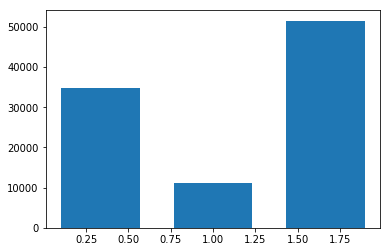

In [72]:
# распределение целевой переменной для 3-х зачений
# видим, что распределение неравномерное 
# попытка приведения распределения к равномерному, удалением context_id c большим перевесом в good 
# сильно уменьшало обучающую выборку и ухудшало скор
hist, bins = np.histogram(train['label_num'], bins=3)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

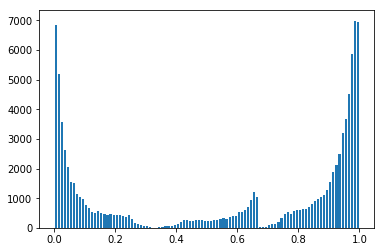

In [74]:
# распределение целевой переменной для всех значений
# видно, что значения для neutral имеют небольшой разброс по частоте
hist, bins = np.histogram(train['y'], bins=100)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

# Обучаемся и делаем предсказание

In [76]:
X_train = train.copy()
y = train['y']
X_test = test.copy()

In [77]:
# выбрасываем вспомогательные поля
X_train.drop(['confidence', 'confidence_delta', 'label', 'label_num', 'y', 'reply_words', 'context_0_words', 'context_1_words', 'context_2_words', 'what_mean'], axis=1, inplace=True)
X_test.drop(['confidence', 'confidence_delta', 'label', 'label_num', 'y', 'reply_words', 'context_0_words', 'context_1_words', 'context_2_words', 'what_mean'], axis=1, inplace=True)

In [78]:
# выбрасываем исходные поля
X_train.drop(['context_2', 'context_1', 'context_0', 'reply'], axis=1, inplace=True)
X_test.drop(['context_2', 'context_1', 'context_0', 'reply'], axis=1, inplace=True)

In [79]:
# выбрасываем id
X_train.drop(['context_id', 'reply_id', 'context_0_gramm_orgn', 'reply_gramm_orgn'], axis=1, inplace=True)
X_test.drop(['context_id', 'reply_id', 'context_0_gramm_orgn', 'reply_gramm_orgn'], axis=1, inplace=True)

In [80]:
# выбрасываем _gramm_order
X_train.drop(['reply_gramm_order', 'context_0_gramm_order'], axis=1, inplace=True)
X_test.drop(['reply_gramm_order', 'context_0_gramm_order'], axis=1, inplace=True)

In [81]:
# выбрасываем _first_word
X_train.drop(['reply_first_word', 'context_0_first_word'], axis=1, inplace=True)
X_test.drop(['reply_first_word', 'context_0_first_word'], axis=1, inplace=True)

In [82]:
# выбрасываем _last_word
X_train.drop(['reply_last_word', 'context_0_last_word'], axis=1, inplace=True)
X_test.drop(['reply_last_word', 'context_0_last_word'], axis=1, inplace=True)

In [83]:
# выбрасываем _len
X_train.drop(['reply_word_len', 'context_0_word_len', 'reply_char_len'], axis=1, inplace=True)
X_test.drop(['reply_word_len', 'context_0_word_len', 'reply_char_len'], axis=1, inplace=True)

In [84]:
# найдём и удалим признаки с небольшим количеством примеров
for c in X_train.columns:
    if (type(X_train[c][0])==np.bool_) & (len(X_train[X_train[c]==True]) < 31):
        print(c)
        X_train.drop([c], axis=1, inplace=True)
        X_test.drop([c], axis=1, inplace=True)

reply_gramm_patr
context_0_gramm_patr
context_0_gramm_involvement_incl
reply_gramm_case_gen2


In [85]:
cat_features = np.where(X_train.dtypes == 'object')[0].tolist()
print("\n".join(X_train.columns[cat_features]))

reply_gramm_pos_first
reply_gramm_case_first
reply_gramm_gender_first
reply_gramm_number_first
reply_gramm_animacy_first
reply_gramm_tense_first
reply_gramm_aspect_first
reply_gramm_person_first
reply_gramm_involvement_first
reply_gramm_mood_first
reply_gramm_transitivity_first
reply_gramm_voice_first
reply_gramm_pos_last
reply_gramm_case_last
reply_gramm_gender_last
reply_gramm_number_last
reply_gramm_animacy_last
reply_gramm_tense_last
reply_gramm_aspect_last
reply_gramm_person_last
reply_gramm_involvement_last
reply_gramm_mood_last
reply_gramm_transitivity_last
reply_gramm_voice_last
context_0_gramm_pos_first
context_0_gramm_case_first
context_0_gramm_gender_first
context_0_gramm_number_first
context_0_gramm_animacy_first
context_0_gramm_tense_first
context_0_gramm_aspect_first
context_0_gramm_person_first
context_0_gramm_involvement_first
context_0_gramm_mood_first
context_0_gramm_transitivity_first
context_0_gramm_voice_first
context_0_gramm_pos_last
context_0_gramm_case_last
cont

In [86]:
file_name = 'final_catboost_1000_seed_17_new_features_corrected_12'

In [87]:
%%time
model = CatBoostRegressor(random_seed=17, iterations=1000, depth=12, logging_level='Silent')
model.fit(X_train, y, cat_features=cat_features);

Wall time: 1h 9min 31s


In [88]:
%%time
preds = model.predict(X_test)

Wall time: 7.45 s


In [89]:
test_to_save = test.copy()
test_to_save['result'] = preds
test_to_save.sort_values(by=['context_id', 'result'], ascending=[1, 0], inplace=True)
test_to_save[['context_id', 'reply_id']].to_csv(file_name + '.csv', encoding='utf-8', sep=' ', index=False, header=False)
test_to_save.to_csv('full_' + file_name + '.csv', encoding='utf-8', sep=' ', index=False)

In [90]:
model.save_model(file_name + '.cbm')

In [91]:
cb_feature_importances = pd.DataFrame(X_test.columns, model.feature_importances_).sort_index(ascending=False)

In [92]:
for i, row in cb_feature_importances.iterrows():
    print(i, row[0])

5.16575629164592 reply_first_word_rife
4.945148491765426 context_0_first_word_rife
4.204964722823379 context_0_last_word_rife
4.147606899156413 reply_gramm_pos_first
4.147570217736325 reply_last_word_rife
3.076522428062693 reply_context_0_intersection_part
2.7786566499572407 reply_gramm_order_rife
1.9340266709895186 reply_gramm_case_last
1.9172303715770969 context_0_gramm_order_rife
1.8334085220382417 context_1_rife
1.8257901279320314 context_2_rife
1.64477923135395 reply_gramm_pos_last
1.5990919095614886 reply_gramm_case_first
1.5899851217198242 context_0_gramm_case_last
1.453182327997118 context_0_gramm_pos_first
1.3247254186244133 reply_gramm_person_last
1.3154241568629021 reply_gramm_person_first
1.2934415607615874 context_0_gramm_pos_last
1.2779902722088825 context_0_question
1.272529856574806 reply_question
1.1529365329435022 context_0_gramm_gender_last
1.061545123502539 context_0_gramm_person_first
1.0490560630948034 reply_gramm_pos_CONJ
1.0187786403171095 reply_gramm_animacy_la

In [93]:
cb_feature_importances.to_csv(file_name + '_feature_importances.csv', sep='\t', header=False)

## Среднее по разным сидам
Пробовал усреднять непосредственно по предсказанным значениям, но оказалось, что для разных моделей они лежат в разных диапазонах и результат оказался неудовлетворительный.
Поэтому беру результат ранжирования, сделанного по предсказанным значениям, выставляю ранги, беру среднее значение ранга для reply_id и финальный результат получаю сортировкой по этим усреднённым рангам.

In [ ]:
file_name = 'final_remote_catboost_1_new_features_corrected_depth_12_seed_'

In [ ]:
# при генерации с разными "случайными" сидами заметил, что часто catboost выдаёт одинаковый результат для разных значений 
# (вроде бы это можно определить по cкору на первой итерации), поэтому подбирал значения, чтобы резуьтат был уникальным
files = []
for e in [11, 17, 27, 42, 44, 71, 101, 335, 888, 999, 1107]:
    model = CatBoostRegressor(random_seed=e, iterations=1, depth=12)
    model.fit(X_train, y, cat_features=cat_features, logging_level='Info');
    preds = model.predict(X_test)
    test_to_save = test.copy()
    test_to_save['result'] = preds
    test_to_save.sort_values(by=['context_id', 'result'], ascending=[1, 0], inplace=True)
    result_filename = file_name + '_' + str(e) + '.csv'
    files.append(result_filename)
    test_to_save[['context_id', 'reply_id']].to_csv(result_filename, encoding='utf-8', sep=' ', index=False, header=False)
    cb_feature_importances = pd.DataFrame(X_test.columns, model.feature_importances_).sort_index(ascending=False)
    cb_feature_importances.to_csv(file_name + '_' + str(e) + '_feature_importances.csv', sep='\t', header=False)

In [ ]:
results = []
def Ordr(row):
    row['rank'] = range(0, len(row))
    return row
for file in files:
    df = pd.read_csv(file, sep=' ', header=None, names=[ 'context_id', 'reply_id'])
    df = df.groupby('context_id').apply(Ordr)
    df.sort_values(by=['context_id', 'reply_id'], ascending=[1, 1], inplace=True)
    results.append(df['rank'].astype('float'))
result = np.mean(results, axis=0)
print(len(result))

test_to_save = test.copy()
test_to_save['rank'] = result

file_name_mean = file_name + '_mean.csv'
test_to_save.sort_values(by=['context_id', 'rank'], ascending=[1, 1], inplace=True)
test_to_save[['context_id', 'reply_id']].to_csv(file_name_mean, encoding='utf-8', sep=' ', index=False, header=False)